<a href="https://colab.research.google.com/github/christinacdl/Text_Classification_Transformers/blob/main/Text_Classification_Offensive__Language_Detection__Tweets_Trainer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **TRANSFORMING TEXT WITH TRANSFORMERS: A JOURNEY INTO TEXT CLASSIFICATION FOR OFFENSIVE LANGUAGE DETECTION ON SOCIAL MEDIA**

**USING THE TRANSFORMERS TRAINER FROM HUGGING FACE**

In [1]:
# Install PyTorch 2.0 with cuda 11.7
!pip install "torch>=2.0" --extra-index-url https://download.pytorch.org/whl/cu117 --upgrade --quiet
# Install transformers and dataset
!pip install "transformers==4.27.1" "datasets==2.9.0" "accelerate==0.17.1" "evaluate==0.4.0" tensorboard scikit-learn
# Install git-fls for pushing model and logs to the hugging face hub
!sudo apt-get install git-lfs --yes

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Reading package lists... Done
Building dependency tree       
Reading state information... Done
git-lfs is already the newest version (2.9.2-1).
0 upgraded, 0 newly installed, 0 to remove and 38 not upgraded.


In [2]:
# Install dependencies
!pip install -U huggingface_hub torch lightning focal_loss_torch pytorch_metric_learning SentencePiece emoji unidecode ekphrasis -U contractions torchvision wordsegment

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
# Import necessary libraries
import torch
from torchtext import data, datasets
import random
import re 
import glob 
import spacy
import string 
import time
import emoji
import pandas as pd  
import seaborn as sns
import math
import numpy as np
import nltk
import pickle
from tqdm import tqdm, trange
import datetime
import torch.nn as nn
import torch.optim as optim
import collections
from sklearn.utils import resample
from sklearn import metrics
import torchmetrics
import spacy
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score,  matthews_corrcoef
from sklearn.metrics import classification_report
from functools import reduce
import os
import copy
import shutil
import torch.nn.functional as F
import itertools
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc
from transformers import AdamW, get_linear_schedule_with_warmup, BertForSequenceClassification, XLMRobertaXLForSequenceClassification, XLMRobertaXLConfig, AutoTokenizer, AutoModelForSequenceClassification, AutoConfig, BertConfig, BertModel, BertTokenizer 
import matplotlib.pyplot as plt 
import torchvision
from typing import Callable
from lightning import Fabric
import contractions
import unicodedata
from transformers import pipeline, Trainer, TrainingArguments, EarlyStoppingCallback
from huggingface_hub import HfFolder, login
from datasets import load_dataset

**SET UP THE DEVICE**

In [4]:
# Set up GPU for Training
if torch.cuda.is_available():       
  device = torch.device('cuda')
  print(f'There are {torch.cuda.device_count()} GPU(s) available.')
  print('Device name:', torch.cuda.get_device_name(0))
else:
  print('No GPU available, using the CPU instead.')
  device = torch.device('cpu')

INFO: Using 16-bit Automatic Mixed Precision (AMP)
INFO:lightning.pytorch.utilities.rank_zero:Using 16-bit Automatic Mixed Precision (AMP)
INFO: You are using a CUDA device ('NVIDIA A100-SXM4-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
INFO:lightning.pytorch.utilities.rank_zero:You are using a CUDA device ('NVIDIA A100-SXM4-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


There are 1 GPU(s) available.
Device name: NVIDIA A100-SXM4-40GB


**ACCESS YOUR HUGGING FACE ACCOUNT USING THE ACCESS TOKEN**

In [5]:
# If you have a Hugging Face account, log in to the Hugging Face website. Go to your 'settings/tokens' and copy to clipboard your user access token
login(token=" ", add_to_git_credential = True)

Token is valid (permission: write).
Your token has been saved in your configured git credential helpers (store).
Your token has been saved to /root/.cache/huggingface/token
Login successful


**INITIALIZE NECESSARY FUNCTIONS**

In [6]:
# A function that sets seed for reproducibility
def set_seed(seed_value): 
  random.seed(seed_value)
  np.random.seed(seed_value)
  torch.manual_seed(seed_value)
  torch.cuda.manual_seed_all(seed_value)


# A function that checks if a directory exists else creates the directory 
def check_create_path(path): 
  if not os.path.exists(path):
    os.makedirs(path)
    print('Directory created at {}'.format(path))
  else:
    print('Directory {} already exists!'.format(path))


# A function that reads a csv or tsv file, removes missing values and duplicates 
def read_a_file(filename):
  # Check first whether a certain file or directory exists
  if os.path.exists(filename):
    print('Current file opened: ',[os.path.join(filename, file) for file in glob.glob(filename)])
      
    # Find the file extension to open it properly
    find_separator = {'.csv': ',', '.tsv': '\t'}
    basename, format = os.path.splitext(filename)
    assert format in find_separator
    separator = find_separator[format]  
    
    # Read different extensions of files using pandas with 2 different separators     
    read_file = pd.read_csv(filename, sep = separator, encoding = 'utf-8')
    
    return read_file
    
  else:
    print('File or directory not accessible. Please check the filename and ensure that the entered path of the file is in "tsv" or "csv" form.')


def open_dataset(dataset_path, text_column, label_column, huggingface_dataset = True, type_split = 1, labelled_dataset = True):

  if huggingface_dataset:
    if type_split == 1:
      dataset = load_dataset(dataset_path, split='train')
      read_file = pd.DataFrame(dataset)
    elif type_split == 2:
      dataset = load_dataset(dataset_path, split='validation')
      read_file = pd.DataFrame(dataset)
    elif type_split == 3:
      dataset = load_dataset(dataset_path, split='test')
      read_file = pd.DataFrame(dataset)
    else:
      print('Please specify the number "1" for train set, "2" for validation and "3" to use the test set.')
            
  else:
    read_file = read_a_file(dataset_path)
    
  read_file.info()
    
  # Get the keys and their corresponding number of values
  keys = read_file.keys() 
  for key in keys:
    df_len = len(read_file[key].unique()) # the length of the unique values of each column
    print('{0:25}{1:10}'.format(key,df_len))
    
  # Remove missing values and keep the dataFrame with valid entries in the same variable
  read_file.dropna(inplace = True) 
          
  # Remove the index
  read_file.reset_index(inplace = True, drop = True)
    
  if text_column != 'text':
    read_file = read_file.rename({text_column:'text'}, axis = 1)
  else:
    read_file
        
  if label_column != 'label':
    read_file = read_file.rename({label_column:'label'}, axis = 1)
  else:
    read_file
    
  print(read_file.label.value_counts())
    
  if labelled_dataset:
    # Encode the concatenated data
    encoded_texts = [tokenizer.encode(sent, add_special_tokens = True) for sent in read_file.text.values]
    
    # Find the maximum length
    max_len = max([len(sent) for sent in encoded_texts])
    print('Maximum sentence length: ', max_len)
    
    # Find the minimum length
    min_len = min([len(sent) for sent in encoded_texts])
    print('Minimum sentence length: ', min_len)
      
  else:
    None 
    
  return read_file

In [7]:
#=== METRICS CALCULATION ===

def plot_roc_curve(true, preds): 
  fpr, tpr, threshold = metrics.roc_curve(true, preds)
  roc_auc = metrics.auc(fpr, tpr)
  lw = 2
  plt.figure()
  plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
  plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver Operating Characteristic')
  plt.legend(loc='lower right')
  plt.show()


def show_confusion_matrix1(true, predicted, class_names):
  cm = confusion_matrix(true, predicted)
  df_cm = pd.DataFrame(cm, index = class_names, columns = class_names)
  hmap = sns.heatmap(df_cm, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True Labels')
  plt.xlabel('Predicted Labels')


# A function that calculates all the metrics using the validation/test set
def calculate_metrics(y_true, preds):  
  print('\nCalculating metrics...')
  assert len(preds) == len(y_true)

  # Calculate the accuracy of the model 
  acc = accuracy_score(y_true, preds)

  # Calculate the Matthews Correlation Coefficient  
  # -1 indicates total disagreement between predicted classes and actual classes
  # 0 is synonymous with completely random guessing
  # 1 indicates total agreement between predicted classes and actual classes
  mcc = matthews_corrcoef(y_true, preds)

  # Calculate model's metrics
  model_f1_score = f1_score(y_true, preds, average = 'macro', zero_division = 1)
  model_precision = precision_score(y_true, preds, average = 'macro', zero_division = 1)
  model_recall = recall_score(y_true, preds, average = 'macro', zero_division = 1)
  
  # Calculate general precision, recall, F1 score of each class
  precision, recall, fscore, support = score(y_true, preds, zero_division = 1)
  print('Accuracy: {}'.format(acc))
  print('F1 score: {}'.format(model_f1_score))
  print('Precision: {}'.format(model_precision))
  print('Recall : {}'.format(model_recall))
  print('Matthews Correlation Coefficient: {}'.format(mcc))
  print('\nPrecision of each class: {}'.format(precision))
  print('Recall of each class: {}'.format(recall))
  print('F1 score of each class: {}'.format(fscore))
  
  class_names = ['NOT', 'OFF']

  # Print the classification report
  class_report = classification_report(y_true, preds, target_names = class_names, zero_division = 1)
  print(class_report)

  show_confusion_matrix1(y_true, preds, class_names)

  return class_report


# A function to compute metrics during model evaluation
def compute_metrics(p):
  logits = p.predictions[0] if isinstance(p.predictions, tuple) else p.predictions
  preds = np.argmax(logits, axis=1)
  macro_f1 = f1_score(y_true=p.label_ids, y_pred=preds, average='macro', zero_division=0)
  micro_f1 = f1_score(y_true=p.label_ids, y_pred=preds, average='micro', zero_division=0)
  accuracy = accuracy_score(y_true=p.label_ids, y_pred=preds)
  return {'macro_f1': macro_f1, 'micro_f1': micro_f1, 'accuracy': accuracy}

In [8]:
# Tokenize helper function
def tokenize(batch):
    return tokenizer(batch['text'], max_length = args['max_seq_length'], padding = 'max_length', truncation = True, return_tensors = 'pt')

**THE TASK LABELS**

In [24]:
# Determine the number of labels in the data and map each of these labels to an index.
labels_to_id = {'NOT': 0 , 'OFF': 1}
id_to_labels = { 0 : 'NOT', 1 : 'OFF',}
print(f'LABELS: \n {labels_to_id}')

LABELS: 
 {'NOT': 0, 'OFF': 1}


**NECESSARY & IMPORTANT PARAMETERS**

In [21]:
dict_BERT_model_names = {1: 'bert-base-uncased', 
                         2: 'bert-large-uncased',
                         3: 'bert-base-multilingual-uncased', #multilingual
                         4: 'bert-base-multilingual-cased',   #multilingual
                         5: 'vinai/bertweet-base'} 
                    
dict_XLM_RoBERTa_model_names = {1: 'xlm-roberta-base',   #multilingual
                                2: 'xlm-roberta-large'}  #multilingual

dict_multilingual_model_names = {1: 'studio-ousia/mluke-base', #multilingual
                                 3: 'cvcio/comments-el-toxic', #multilingual
                                 4: 'microsoft/mdeberta-v3-base'} # Finetuned on Greek dataset

dict_AlBERT_model_names = {1: 'albert-base-v1',
                           2: 'albert-base-v2',
                           3: 'albert-xlarge-v1',
                           4: 'albert-xlarge-v2',
                           5: 'albert-xxlarge-v1',
                           6: 'albert-xxlarge-v2'}

dict_RoBERTa_model_names = {1: 'roberta-base',
                            2: 'roberta-large'} 

dict_DeBERTa_model_names = {1: 'microsoft/deberta-base',
                            2: 'microsoft/deberta-large',
                            3: 'microsoft/deberta-xlarge',
                            4: 'microsoft/deberta-v2-xlarge',
                            5: 'microsoft/deberta-v2-xxlarge',
                            6: 'microsoft/deberta-v3-large'}              
                           
args = {'task_name': 'Finetuning Transformer Language Models for Offensive Language Detection on English Social Media Texts',
        'data_directory': '/content/drive/MyDrive/ColabNotebooks/Offensive/train_dev_test_data/',
        'results_data_directory': '/content/drive/MyDrive/ColabNotebooks/Offensive/results/', 
        'output_model_directory': '/content/drive/MyDrive/ColabNotebooks/Offensive/Models_dir/', 
        'model_type':  'other',   # Write the model's name 
        'model_name': str(dict_DeBERTa_model_names[6]),   # Change the index to train with the model of your choice   
        'num_classes': 2,      
        'max_seq_length': 512,   
        'train_batch_size': 8, 
        'validation_batch_size': 10,     
        'num_train_epochs': 4,  # Suggested training epochs for BERT fine-tuning: 2,3,4
        'warmup_steps': 0,  
        'weight_decay':  0.01,   # Weight decay is a form of regularization to lower the chance of overfitting 
        'learning_rate': 2e-5,   # Suggested learning rates for BERT fine-tuning: 2e-5, 3e-5, 5e-5  
        'adam_epsilon': 1e-8,    # The bias correction term (Default: 1e-8)
        'seed': 42,
        'gradient_accumulation_steps': 2}

print('================',str(args['task_name']),'================\n')

# Get the directory names and the specific model used 
print('Output directory: ' + str(args['output_model_directory']))
print('Model Name: ' + str(args['model_name']))
args['output_specific_model_dir'] = args['output_model_directory'] + args['model_name'] + '/'
print('Output Directory: ' + str(args['output_specific_model_dir']))

# Check whether the directories exist else create them
print('\nChecking that the necessary paths exist...')
check_create_path(args['data_directory'])
check_create_path(args['results_data_directory'])
check_create_path(args['output_model_directory'])
check_create_path(args['output_specific_model_dir'])

MODEL_CLASSES = {'bert': (BertConfig, BertForSequenceClassification, BertTokenizer),
                 'xlm_roberta': (XLMRobertaXLConfig, XLMRobertaXLForSequenceClassification, AutoTokenizer),
                 'other': (AutoConfig, AutoModelForSequenceClassification, AutoTokenizer)}
                 
config_class, model_class, tokenizer_class = MODEL_CLASSES[args['model_type']]

# Set seed for reproducibility
set_seed(args['seed'])

================ Finetuning Transformer Language Models for Offensive Language Detection on English Social Media Texts ================

Output directory: /content/drive/MyDrive/ColabNotebooks/Offensive/Models_dir/
Model Name: microsoft/deberta-v3-large
Output Directory: /content/drive/MyDrive/ColabNotebooks/Offensive/Models_dir/microsoft/deberta-v3-large/

Checking that the necessary paths exist...
Directory /content/drive/MyDrive/ColabNotebooks/Offensive/train_dev_test_data/ already exists!
Directory /content/drive/MyDrive/ColabNotebooks/Offensive/results/ already exists!
Directory /content/drive/MyDrive/ColabNotebooks/Offensive/Models_dir/ already exists!
Directory /content/drive/MyDrive/ColabNotebooks/Offensive/Models_dir/microsoft/deberta-v3-large/ already exists!


**INITIALIZE THE PRETRAINED LANGUAGE TRANSFORMER MODEL AND ITS TOKENIZER**

In [22]:
config = config_class.from_pretrained(args['model_name'], 
                                      num_labels = args['num_classes'],                                  
                                      finetuning_task = args['task_name']) 

tokenizer = tokenizer_class.from_pretrained(args['model_name'], do_lower_case = False)

tokenizer.add_tokens(['<hashtag>', '</hashtag>', '<OFF>'], special_tokens = True)

model = model_class.from_pretrained(args['model_name'], 
                                    num_labels = args['num_classes'], # The number of output labels 
                                    output_attentions = False,        # Whether the model returns attentions weights
                                    output_hidden_states = False,
                                    id2label = id_to_labels,
                                    label2id = labels_to_id)
                                                                               
model.resize_token_embeddings(len(tokenizer))   

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:446: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Some weights of the model checkpoint at microsoft/deberta-v3-large were not used when initializing DebertaV2ForSequenceClassification: ['lm_predictions.lm_head.LayerNorm.weight', 'lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.bias', 'mask_predictions

Embedding(128004, 1024)

In [12]:
train_set = load_dataset('christinacdl/Offensive_Twitter_Dataset', split = 'train')
val_set = load_dataset('christinacdl/Offensive_Twitter_Dataset', split = 'validation')
test_set = load_dataset('christinacdl/Offensive_Twitter_Dataset', split = 'test')

In [13]:
# Tokenize dataset
train_dataloader = train_set.map(tokenize, batched = True, remove_columns = ['text'])
val_dataloader = val_set.map(tokenize, batched = True, remove_columns = ['text'])
test_dataloader = test_set.map(tokenize, batched = True, remove_columns=['text'])

train_dataloader.set_format(type = 'torch', columns = ['input_ids', 'attention_mask', 'label'])
val_dataloader.set_format(type = 'torch', columns = ['input_ids', 'attention_mask', 'label'])
test_dataloader.set_format(type = 'torch', columns = ['input_ids', 'attention_mask', 'label'])

print(train_dataloader.features.keys())

  0%|          | 0/65 [00:00<?, ?ba/s]

  0%|          | 0/17 [00:00<?, ?ba/s]

  0%|          | 0/5 [00:00<?, ?ba/s]

dict_keys(['label', 'input_ids', 'token_type_ids', 'attention_mask'])


In [14]:
repository_id = 'DeBERTa_Offensive_English_Twitter'

args = TrainingArguments(
    output_dir = repository_id, 
    per_device_train_batch_size = args['train_batch_size'],
    per_device_eval_batch_size = args['validation_batch_size'],
    learning_rate = args['learning_rate'],
    num_train_epochs = args['num_train_epochs'],
    fp16 = True,
    fp16_full_eval = True,
    optim = "adamw_torch_fused", 
    logging_dir = f"{repository_id}/logs",
    logging_strategy = "steps",
    logging_steps = 200,
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    save_total_limit = 2,
    load_best_model_at_end = True,
    report_to = "tensorboard",
    push_to_hub = True,
    hub_strategy = "every_save",
    hub_model_id = repository_id,
    hub_token = HfFolder.get_token(),
    metric_for_best_model = 'macro_f1',
    greater_is_better = True,
    weight_decay = args['weight_decay'],
    overwrite_output_dir = True,
    seed = args['seed'],
    warmup_steps = args['warmup_steps'],
    gradient_accumulation_steps = args['gradient_accumulation_steps'])
  

trainer = Trainer(model = model,
                  args = args,
                  train_dataset = train_dataloader, 
                  eval_dataset = val_dataloader,
                  compute_metrics = compute_metrics,
                  callbacks = [EarlyStoppingCallback(early_stopping_patience=3)])

Cloning https://huggingface.co/christinacdl/DeBERTa_Offensive_English_Twitter into local empty directory.


In [15]:
train_result = trainer.train()

Epoch,Training Loss,Validation Loss,Macro F1,Micro F1,Accuracy
0,0.304500,0.304160,0.890272,0.896810,0.896810
2,0.293500,0.306763,0.887671,0.892103,0.892103
2,0.247800,0.274644,0.903086,0.907216,0.907216
3,0.204100,0.252650,0.907247,0.911366,0.911366


In [16]:
# Save processor and create model card
tokenizer.save_pretrained(repository_id)
trainer.create_model_card()
trainer.push_to_hub()

Several commits (2) will be pushed upstream.
The progress bars may be unreliable.


Upload file pytorch_model.bin:   0%|          | 1.00/1.62G [00:00<?, ?B/s]

Upload file spm.model:   0%|          | 1.00/2.35M [00:00<?, ?B/s]

Upload file logs/events.out.tfevents.1686251448.8f70154620ff.57573.0:   0%|          | 1.00/18.5k [00:00<?, ?B…

To https://huggingface.co/christinacdl/DeBERTa_Offensive_English_Twitter
   e3c0dd3..5851130  main -> main

   e3c0dd3..5851130  main -> main



'https://huggingface.co/christinacdl/DeBERTa_Offensive_English_Twitter/commit/585113062b7f06245e5391096af11151aa1604e2'

***** train metrics *****
  epoch                    =         4.0
  total_flos               = 224172746GF
  train_loss               =      0.2679
  train_runtime            =  2:55:27.06
  train_samples            =       64577
  train_samples_per_second =      24.538
  train_steps_per_second   =       1.534


***** eval metrics *****
  epoch                   =        4.0
  eval_accuracy           =     0.9114
  eval_loss               =     0.2527
  eval_macro_f1           =     0.9072
  eval_micro_f1           =     0.9114
  eval_runtime            = 0:03:02.92
  eval_samples            =      16145
  eval_samples_per_second =     88.262
  eval_steps_per_second   =      8.829

Calculating metrics...
Accuracy: 0.9203707604803033
F1 score: 0.9030805039045081
Precision: 0.8948599346467434
Recall : 0.9127112237048041
Matthews Correlation Coefficient: 0.8073738336608549

Precision of each class: [0.95849624 0.83122363]
Recall of each class: [0.9299679  0.89545455]
F1 score of each class: [0.94401659 0.86214442]
              precision    recall  f1-score   support

         NOT       0.96      0.93      0.94      3427
         OFF       0.83      0.90      0.86      1320

    accuracy                           0.92      4747
   macro avg       0.89      0.91      0.90      4747
weighted avg   

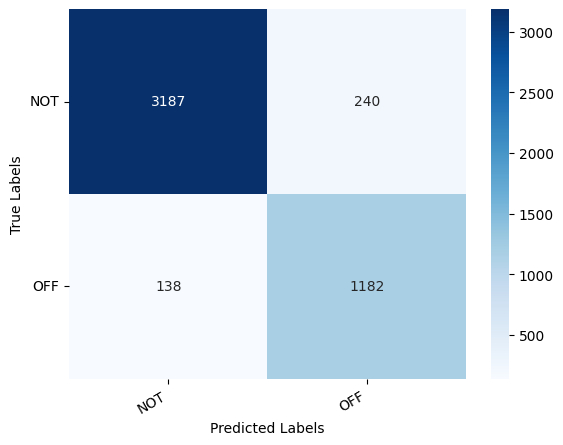

In [17]:
# Train metrics and model save
metrics = train_result.metrics
metrics["train_samples"] = len(train_dataloader)
trainer.save_model()
trainer.log_metrics("train", metrics)
trainer.save_metrics("train", metrics)
trainer.save_state()

# Eval metrics
metrics = trainer.evaluate(eval_dataset= val_dataloader)
max_eval_samples =  len(val_dataloader)
metrics["eval_samples"] = max_eval_samples
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

# Predict metrics and Classification Report
predicted_labels, true_labels, metrics = trainer.predict(test_dataloader, metric_key_prefix="predict")
max_predict_samples = len(test_dataloader)
metrics["predict_samples"] = len(test_dataloader)

classification_report = calculate_metrics(true_labels, np.argmax(predicted_labels, axis=-1))

# Log metrics
trainer.log_metrics("predict", metrics)
trainer.save_metrics("predict", metrics)

In [27]:
# load model from huggingface.co/models using our repository id
classifier = pipeline("text-classification", model = repository_id, tokenizer = repository_id, device = 0)

sample = "what the fuck did he do this time?"

pred = classifier(sample) 
print(pred)

[{'label': 'NOT', 'score': 0.9837743043899536}]
